# <font color='#eb3483'> Evaluation on Imbalanced Datasets </font>
Sometimes our datasets don't naturally have an equal split of data amongst groups. Think of spam detection - the majority of e-mails you get aren't spam, maybe only about 1% of emails actually are spam. So a spam filter that just says everything is not spam will get 99% accuracy, but that's clearly not the best we can do! In this module we'll explore the issue in a little more depth and highlight the importance of all the different model evaluation tools we learned.

In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
sns.set(rc={'figure.figsize':(6,6)}) #Set our seaborn aesthetics (we're going to customize our figure size)

import warnings
warnings.simplefilter("ignore")

# <font color='#eb3483'> Our Data </font>

First we create a function that evaluates a model and produces all of the metrics

In [2]:
def evaluate_model(true_classes, predictions):
    accuracy = metrics.accuracy_score(true_classes, predictions)
    precision = metrics.average_precision_score(true_classes, predictions)
    recall = metrics.recall_score(true_classes, predictions)
    auc = metrics.roc_auc_score(true_classes, predictions)
    f1 = metrics.f1_score(true_classes, predictions)
    print("""
    Accuracy: {:.3f}
    Precision: {:.3f}
    Recall: {:.3f}
    AUC: {:.3f}
    F1 Score: {:.3f}
    """.format(
        accuracy, 
        precision,
        recall,
        auc,
        f1
    ))

For this section we are going to use an imbalanced dataset. It is a dataset taken (with some modifications) from a Kaggle Competition.

https://www.kaggle.com/c/GiveMeSomeCredit/data

The goal for this dataset is: 

>Improve on the state of the art in credit scoring by predicting the probability that somebody will experience financial distress in the next two years. 

In [3]:
credits_df = pd.read_csv("data/cs-training.csv")

In [4]:
credits_df.shape

(120269, 11)

In [5]:
credits_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,1,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,1,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,1,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
target = "SeriousDlqin2yrs"

In [7]:
X = credits_df.drop(columns=target)
y = credits_df[target]

X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [8]:
y.value_counts(normalize=True)

1    0.930514
0    0.069486
Name: SeriousDlqin2yrs, dtype: float64

We see this dataset has 93% of positive cases, that is, 93% of the people in the dataset have finantial distress after 2 years.

Lets train a logistic classifier on this dataset.

In [9]:
model = LogisticRegression()

model.fit(X_train_credit, y_train_credit)

predictions_credit = model.predict(X_test_credit)
true_classes_credit = y_test_credit
prediction_probabilities_credit = model.predict_proba(X_test_credit)

Now we evaluate the model

In [10]:
evaluate_model(true_classes_credit, predictions_credit)


    Accuracy: 0.930
    Precision: 0.931
    Recall: 0.999
    AUC: 0.504
    F1 Score: 0.964
    


We see that most metrics seem pretty good.  We see accuracy, precision, recall and F1 are high, why is that? 

We have to remember, **93% of the observations are of the positive class and only 7% of observations are negatives**. We call this **imbalanced classes**. Training on class imbalance means that the model is giving more wait to the positive class, choosing to assign a 1 whenever possible. 

In [11]:
# Our ROC Curve Function from Class
def roc_curve(true_classes, predictions, prediction_probabilities):
    fpr, tpr, _ = metrics.roc_curve(true_classes, prediction_probabilities[:,1])
    roc_auc = metrics.roc_auc_score(true_classes, predictions)

    sns.mpl.pyplot.fill_between(fpr, tpr, step='post', alpha=0.2,color='b')
    sns.lineplot(x=fpr, y=tpr, linestyle='--', label='ROC Curve(area = %0.2f)' % roc_auc)
    sns.lineplot(x=[0,1], y= [0,1], linestyle='--', label = 'Random Classifier')
    
    sns.mpl.pyplot.xlabel('FPR')
    sns.mpl.pyplot.ylabel('TPR (recall)')
    sns.mpl.pyplot.title('ROC Curve')


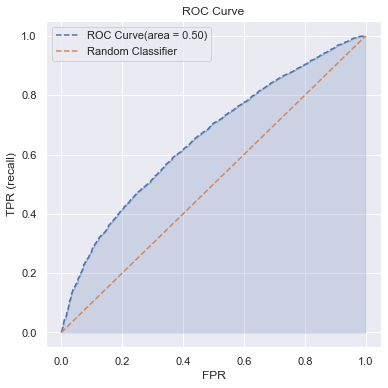

In [12]:
roc_curve(true_classes_credit, predictions_credit, prediction_probabilities_credit)

We see the Area Under the Curve is very low (almost the same as flipping a coin)

In [13]:
confusion_matrix(y_test_credit, predictions_credit)

array([[   21,  2497],
       [   17, 33546]])

We see there are very few Negative observations classified as Negative. But because there are so few Negative observations the metrics that rely on Positive classes are very high.

## <font color='#eb3483'> What is our baseline? </font>

It would be easy to look at the metrics and think our model is good. However, it is always importante to compare the performance of our models with a reasonable baseline.

A reasonable baseline would be a classifier that always predicted the majority class.

What would be the performance of this classifier?

In [14]:
predictions_positive_model = np.ones(true_classes_credit.shape[0])
evaluate_model(true_classes_credit, predictions_positive_model)


    Accuracy: 0.930
    Precision: 0.930
    Recall: 1.000
    AUC: 0.500
    F1 Score: 0.964
    


We see that a model always predicting 1s would have very good performance, except for AUC, that would be the worst possible. That is why for imbalanced datasets, AUC is a much better metric.



## <font color='#eb3483'> How can we decide a threshold? </font>

In [13]:
model = LogisticRegression()
model.fit(X_train_credit, y_train_credit)

predictions = model.predict(X_test_credit)
true_classes = y_test_credit
prediction_probabilities = model.predict_proba(X_test_credit)

In [14]:
probabilities = model.predict_proba(X_test_credit)[:5]
probabilities

array([[0.07966864, 0.92033136],
       [0.18097664, 0.81902336],
       [0.09979811, 0.90020189],
       [0.13229221, 0.86770779],
       [0.02949755, 0.97050245]])

We can filter the probabilities based on a threshold and get False if the predicted class is a 0 or True if its a 1

In [17]:
threshold = 0.5
probabilities[:,1]>=threshold

array([ True,  True,  True,  True,  True])

For example, if we lower the threshold (meaning we are going to *"lower the bar"* and being less picky when we classify a case as positive, effectively classifying everyone as positive)

In [15]:
threshold = 0.1
probabilities[:,1]>=threshold

array([ True,  True,  True,  True,  True])

We have a way to given a threshold, transform probabilities to classes. 

Now we just have to define a way to translate business decisions into a threshold.

What do we mean by that? For any machine learning systems, there are costs to both false positives and false negatives.

For example, if we think about the Breast Cancer Dataset:

- If our classifier predicts a person has a malignant cancer when they dont (*False positive*), they will feel devastated and if they (or we) realize of the mistake, they might sue us! Or maybe they would feel very relieved, so it would be ok?.

- If our classifier predicts that a person has a benign cancer when they actually have a malignant one (*False Negative*), if that person dies, we are probably going to be sued, lose our practice license, or both.

In that example, the cost of a False Positive is probably lower than a False Negative, so we should use a threshold lower than 0.5.

If we can assign a numerical value (a cost) to a False Positive and a False Negative, we can use a function to turn them into a threshold. For example, we can use the *SoftMax* function, which we will see in the future.

In [16]:
def softmax(cost_fp, cost_fn):
    return np.exp(cost_fp) / (np.exp(cost_fn)+np.exp(cost_fp))

cost_fn = 1
cost_fp = 2 #a false positive is twice as bad as a false negative on this example
softmax(cost_fp, cost_fn)

0.7310585786300049

We can use a widget to see how the threshold changes with the cost

In [17]:
from ipywidgets import widgets, interact

@interact
def calculate_threshold(
    cost_fp=widgets.FloatSlider(min=1, max=10, step=0.1, value=1),
    cost_fn=widgets.FloatSlider(min=1, max=10, step=0.1, value=1),
):
    return softmax(cost_fp, cost_fn)

interactive(children=(FloatSlider(value=1.0, description='cost_fp', max=10.0, min=1.0), FloatSlider(value=1.0,…

In [18]:
#Our probabilities to classes function from class
def probabilities_to_classes(prediction_probabilities, threshold=0.5):
    predictions = np.zeros([len(prediction_probabilities), ])
    predictions[prediction_probabilities[:,1]>=threshold] = 1
    return predictions

In [19]:
cost_fn = 10
cost_fp = 1
threshold = calculate_threshold(cost_fp, cost_fn)
print(threshold)
predicted_classes = probabilities_to_classes(probabilities, threshold)
predicted_classes

0.0001233945759862317


array([1., 1., 1., 1., 1.])

One great thing about scikit-learn is that we can expand the existing classes.

For example, we can expand the class `LogisticRegression` and add a method that takes into acount the business costs of false positives and false negatives.

In [20]:
class BusinessLogisticRegression(LogisticRegression):
        
    def business_decision(self, X, cost_fp=1, cost_fn=1, *args, **kwargs):
        probabilities = self.predict_proba(X)
        threshold = calculate_threshold(cost_fp, cost_fn)
        print("Threshold: {}".format(threshold))
        predicted_classes = probabilities_to_classes(probabilities, threshold)
        return predicted_classes
        
business_decision_model = BusinessLogisticRegression()

business_decision_model.fit(X_train_credit, y_train_credit)        

BusinessLogisticRegression()

In [24]:
business_decision_model.predict(X_test_credit[:5])

array([1, 1, 1, 1, 1])

In [25]:
business_decision_model.predict_proba(X_test_credit[:5])

array([[0.07682023, 0.92317977],
       [0.18285352, 0.81714648],
       [0.11635433, 0.88364567],
       [0.14544341, 0.85455659],
       [0.02953009, 0.97046991]])

In [26]:
cost_fp=1, 
cost_fn=1
business_decision_model.business_decision(X_test_credit[:5], cost_fp, cost_fn)

Threshold: [0.5]


array([1., 1., 1., 1., 1.])

In [21]:
@interact(
    cost_fp=widgets.FloatSlider(min=1.,max=10.,step=.1,value=1.),
    cost_fn=widgets.FloatSlider(min=1.,max=10.,step=.1,value=1.)
)
def business_decision(cost_fp, cost_fn):
    predictions = business_decision_model.business_decision(X_test_credit, cost_fp, cost_fn)
    print(confusion_matrix(true_classes, predictions))

interactive(children=(FloatSlider(value=1.0, description='cost_fp', max=10.0, min=1.0), FloatSlider(value=1.0,…